In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect
import sklearn as sk
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

In [2]:
diamonds = []
num_diamonds = 29
for diamond_num in range(num_diamonds):
    diamond = learning.load_obj("diamonds/diamond_" + str(diamond_num))
    diamonds.append(diamond)

In [3]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [99]:
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"]
    data = diamond["data"]
    N = diamond["N"]
    dip_inds = diamond["dip_inds"]
    windows = diamond["windows"]
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds)))
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii:
        if diamond["good_fits"][dii]:
            dip_ind = dip_inds[dii]
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features):
        return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  374
num_removed:  4
correct:  19 incorrect:  6
diamond_ind:  1
dips measured:  429
num_removed:  0
correct:  21 incorrect:  4
diamond_ind:  2
dips measured:  431
num_removed:  0
correct:  16 incorrect:  9
diamond_ind:  3
dips measured:  357
num_removed:  1
correct:  14 incorrect:  2
diamond_ind:  4
dips measured:  426
num_removed:  1
correct:  11 incorrect:  2
diamond_ind:  5
dips measured:  406
num_removed:  1
correct:  22 incorrect:  3
diamond_ind:  6
dips measured:  406
num_removed:  0
correct:  14 incorrect:  2
diamond_ind:  7
dips measured:  375
num_removed:  0
correct:  14 incorrect:  1
diamond_ind:  8
dips measured:  390
num_removed:  0
correct:  16 incorrect:  1
diamond_ind:  9
dips measured:  445
num_removed:  0
correct:  18 incorrect:  7
diamond_ind:  10
dips measured:  388
num_removed:  0
correct:  10 incorrect:  0
diamond_ind:  11
dips measured:  385
num_removed:  0
correct:  10 incorrect:  3
diamond_ind:  12
dips measured:  375
num_removed: 

analysis.py:61: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt((1 - mz ** 2)) * omega_tilde


In [100]:
np.mean(num_correct_list), np.mean(num_incorrect_list)

(15.0, 2.7241379310344827)

In [2]:
#results_dict = {"As_list" : As_list, "Bs_list" : Bs_list,
#                "num_correct_list" : num_correct_list, "num_incorrect_list" : num_incorrect_list, "dips_measured" : dips_measured}
#learning.store_obj(results_dict, "results/results_di3220_29diamonds_cxABe_x1")
results_dict = learning.load_obj("results/results_di3220_29diamonds_cxABe_x1")
As_list = results_dict["As_list"]
Bs_list = results_dict["Bs_list"]
num_correct_list = results_dict["num_correct_list"]
num_incorrect_list = results_dict["num_incorrect_list"]
dips_measured = results_dict["dips_measured"]
#print np.mean(results_dict["num_correct_list"])#, num_correct_list
#print results_dict["num_incorrect_list"]#, num_incorrect_list
#As_list = results_dict["As_list"]
#Bs_list = results_dict["Bs_list"]

In [5]:
np.mean(np.array(dips_measured) * 128 + 5100)

55298.068965517239

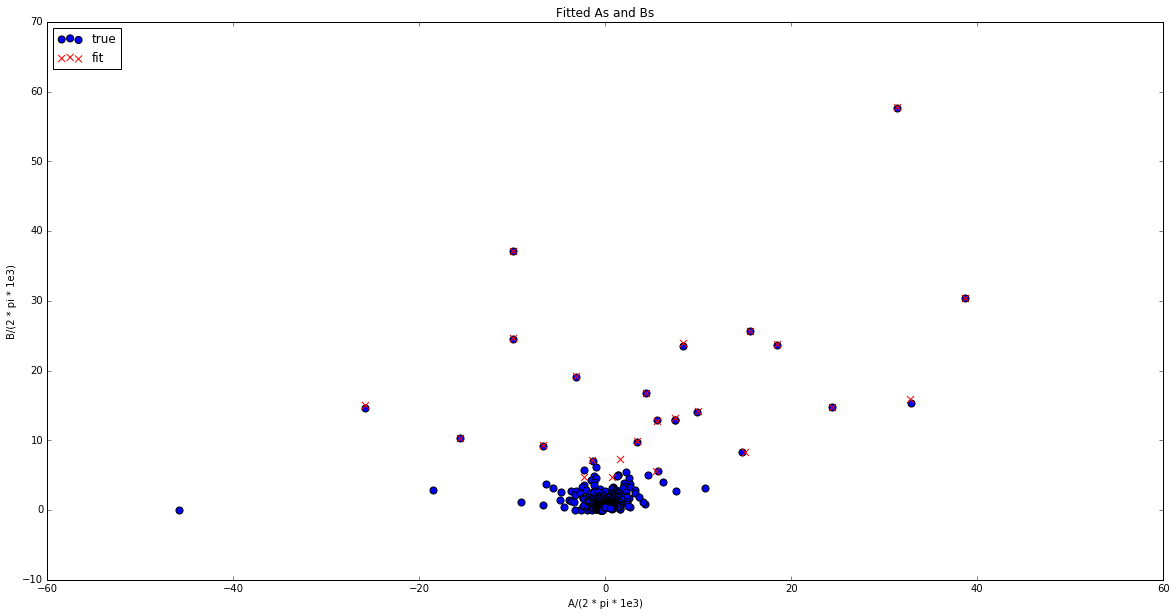

In [83]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(20,10))
plt.title("Fitted As and Bs")
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(diamonds[diamond_ind]["A"]/analysis.mag, np.abs(diamonds[diamond_ind]["B"])/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
plt.scatter(As_list[diamond_ind]/analysis.mag, np.abs(Bs_list[diamond_ind])/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()

In [77]:
tau[100]-tau[99]

3.7262208276133343e-09

# Below here is trash

In [ ]:
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"]
    data = diamond["data"]
    N = diamond["N"]
    dip_inds = diamond["dip_inds"]
    windows = diamond["windows"]
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds)))
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii:
        if diamond["good_fits"][dii]:
            dip_ind = dip_inds[dii]
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features):
        return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

In [42]:
def choose_spin_guesses(spin_dict, N, omega_larmor, tau, data, error_fun = analysis.squared_error):
    guess_As, guess_Bs, guess_Xs, dataerrs = [], [], [], []
    for k in spin_dict.keys():
        err = []
        for A, B in spin_dict[k]:
            err.append(error_fun(analysis.calc_M_single(A, B, N, omega_larmor, tau), data))
        min_err_ind = np.argmin(err)
        best_A, best_B = spin_dict[k][min_err_ind]
        best_err = err[min_err_ind]
        dip_ind, phi, x = k
        guess_As.append(best_A)
        guess_Bs.append(best_B)
        guess_Xs.append(x)
        dataerrs.append(best_err)
    return np.array(guess_As), np.array(guess_Bs), np.array(guess_Xs), np.array(dataerrs)

def cluster_spin_guesses(guess_As, guess_Bs, guess_Xs, dataerrs, eps = .075, min_samples = 1):
    X = sk.preprocessing.StandardScaler().fit_transform(zip(guess_As, guess_Bs)) # possibly need to be lists?
    db = sk.cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(X)
    labels = db.labels_
    cluster_As, cluster_Bs, cluster_dataerrs = [], [], []
    for k in np.unique(labels):
        if k >= 0:
            print k
            label_inds = np.where(labels == k)[0]
            best_guess = np.argmin(dataerrs[label_inds])
            cluster_A, cluster_B, cluster_X, cluster_dataerr = map(lambda arr: arr[label_inds][best_guess],
                                                                   [guess_As, guess_Bs, guess_Xs, dataerrs])
            if cluster_X >= 0:
                cluster_As.append(cluster_A)
                cluster_Bs.append(cluster_B)
                cluster_dataerrs.append(cluster_dataerr)
    return np.array(cluster_As), np.array(cluster_Bs), np.array(cluster_dataerrs)

In [43]:
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
cluster_As_list, cluster_Bs_list = [], []
for diamond_ind in [21]:#range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"]
    data = diamond["data"]
    N = diamond["N"]
    dip_inds = diamond["dip_inds"]
    windows = diamond["windows"]
    def dii_classifier(dii):
        return dip_inds[dii] >= 3220
    clf_dii = filter(dii_classifier, range(len(dip_inds)))
    print "total dips: ", len(dip_inds)
    print "remaining dips: ", len(clf_dii)
    spin_dict = {}
    for dii in clf_dii:
        if diamond["good_fits"][dii]:
            dip_ind = dip_inds[dii]
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B)]
    guess_As, guess_Bs, guess_Xs, dataerrs = choose_spin_guesses(spin_dict, N, omega_larmor, tau, data, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = cluster_spin_guesses(guess_As, guess_Bs, guess_Xs, dataerrs, eps = .075, min_samples = 3)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
#    while num_remove <= 2:
#        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    cluster_As_list.append(cluster_As)
    cluster_Bs_list.append(cluster_Bs)
#    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  21
total dips:  1119
remaining dips:  381
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
correct:  6 incorrect:  31


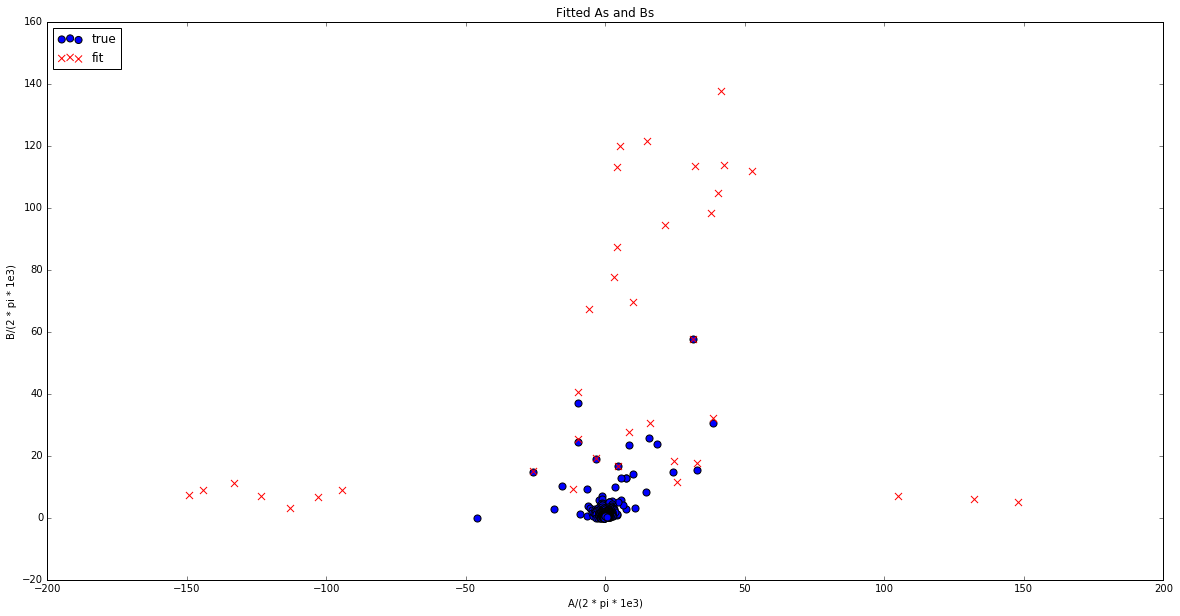

In [44]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(20,10))
plt.title("Fitted As and Bs")
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(diamonds[diamond_ind]["A"]/analysis.mag, np.abs(diamonds[diamond_ind]["B"])/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
plt.scatter(cluster_As/analysis.mag, np.abs(cluster_Bs)/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()

In [5]:
np.mean(num_correct_list), np.mean(num_incorrect_list)

NameError: name 'num_correct_list' is not defined

In [15]:
np.mean([19, 21, 16, 14, 11, 22, 14, 14, 16, 18, 10, 10, 9, 12, 18, 13, 15, 14, 22, 12, 12, 24, 13, 9, 12, 24, 8, 15, 13])
len([6, 4, 9, 1, 2, 3, 2, 1, 1, 7, 0, 3, 1, 1, 0, 2, 3, 4, 2, 4, 3, 1, 4, 0, 3, 7, 1, 2, 1])

29

In [ ]:
dips = [374, 429, 431, 357, ]

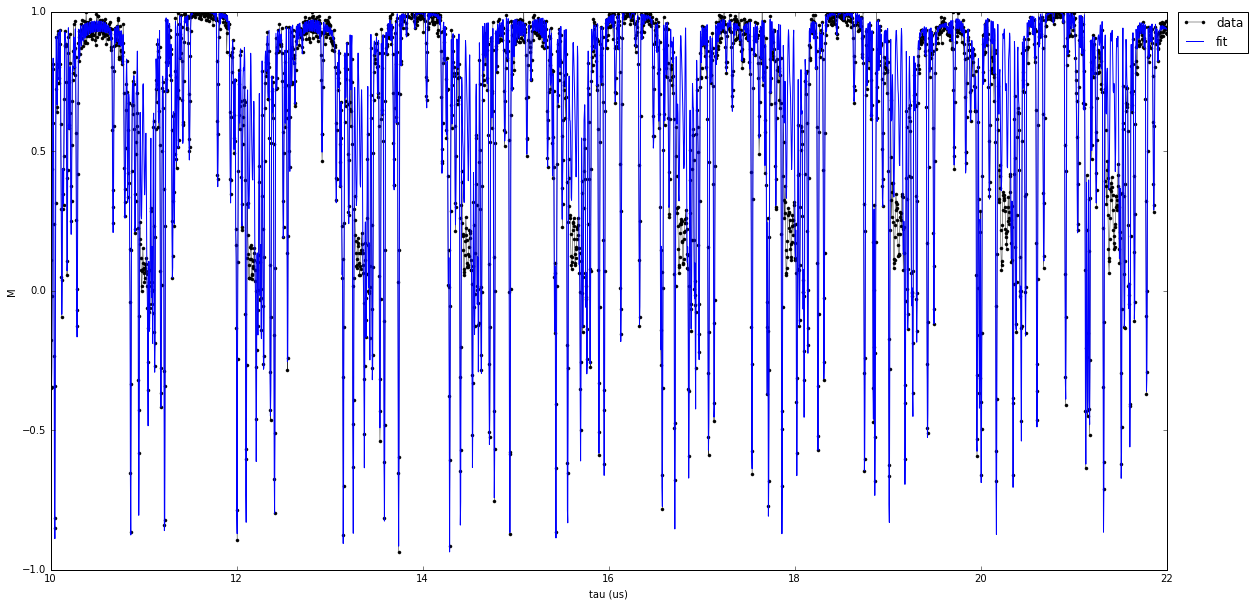

In [128]:
%matplotlib inline
diamond = diamonds[diamond_ind]
fig,ax = analysis.initialize_data_plot(figsize = (20,10), xlims = [10,22], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
tau = diamond["tau"]
ax.plot(tau * 1e6, diamond["data"], '.-k', lw=0.4, label = 'data')
ax.plot(tau * 1e6, analysis.calc_M(As_list[diamond_ind], Bs_list[diamond_ind], diamond["N"], omega_larmor, tau), label = 'fit')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
#plt.title("Simulated M with " + str(len(A_rand)) + " spins for N=" + str(N) +", ms=" + str(ms))
#plt.savefig(figures_path + "dynamical_decoupling_M_simulation_N"+str(N)+"_ms"+str(ms))
plt.show()

In [ ]:
400 * 128/5100

In [91]:
len(tau[3220:] * 1e6)

1880

In [90]:
tau[3220] * 1e6

14.998431064914689

In [93]:
(tau[100]-tau[99])*1e6

0.0037262208276133343

In [30]:
A_test, B_test, _, _, _ = NV_generator.generate_spins(400, verbose = True) #, c13_concentration=1)
print len(A_test)

N: 34
437


In [32]:
A_test, B_test, _, _, _ = NV_generator.generate_spins(400, N = 35, c13_concentration = 1, verbose = True)
print len(A_test)

N: 35


KeyboardInterrupt: 

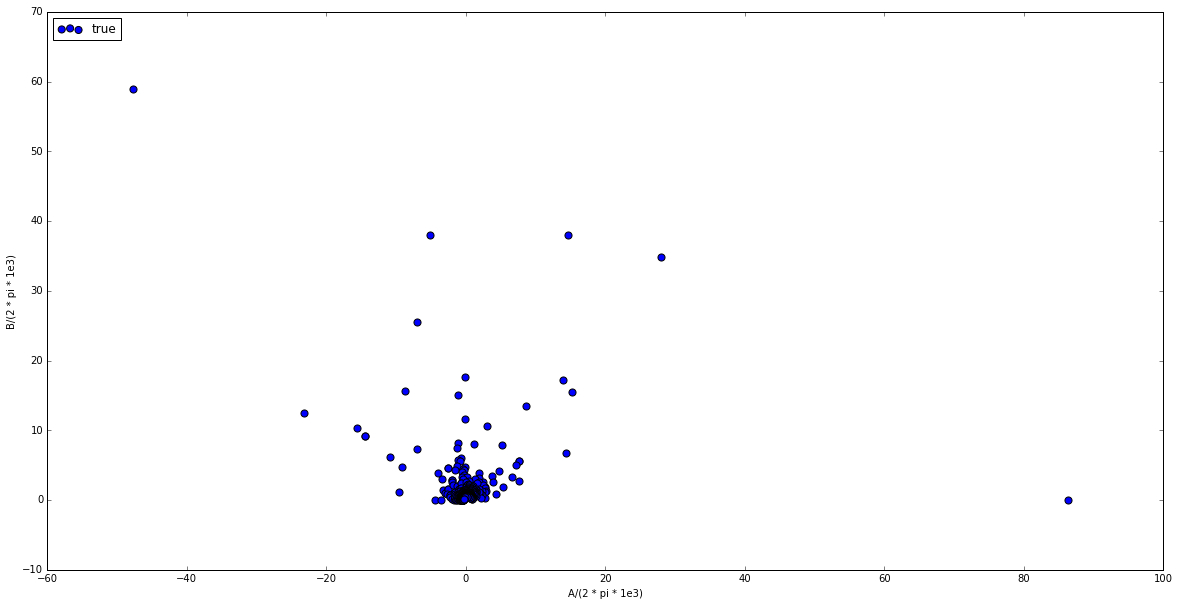

In [28]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(20,10))
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(np.array(A_test)/analysis.mag, np.abs(np.array(B_test))/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
#plt.scatter(As_list[diamond_ind]/analysis.mag, np.abs(Bs_list[diamond_ind])/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()

In [ ]:
diamond_ind:  0
dips measured:  374
num_removed:  4
correct:  19 incorrect:  6
diamond_ind:  1
dips measured:  429
num_removed:  0
correct:  21 incorrect:  4
diamond_ind:  2
dips measured:  431
num_removed:  0
correct:  16 incorrect:  9
diamond_ind:  3
dips measured:  357
num_removed:  1
correct:  14 incorrect:  2
diamond_ind:  4
dips measured:  426
num_removed:  1
correct:  11 incorrect:  2
diamond_ind:  5
dips measured:  406
num_removed:  1
correct:  22 incorrect:  3
diamond_ind:  6
dips measured:  406
num_removed:  0
correct:  14 incorrect:  2
diamond_ind:  7
dips measured:  375
num_removed:  0
correct:  14 incorrect:  1
diamond_ind:  8
dips measured:  390
num_removed:  0
correct:  16 incorrect:  1
diamond_ind:  9
dips measured:  445
num_removed:  1
correct:  18 incorrect:  6
diamond_ind:  10
dips measured:  388
num_removed:  0
correct:  10 incorrect:  0
diamond_ind:  11
dips measured:  385
num_removed:  0
correct:  10 incorrect:  3
diamond_ind:  12
dips measured:  375
num_removed:  0
correct:  9 incorrect:  1
diamond_ind:  13
dips measured:  402
num_removed:  0
correct:  12 incorrect:  1
diamond_ind:  14
dips measured:  397
num_removed:  0
correct:  18 incorrect:  0
diamond_ind:  15
dips measured:  379
num_removed:  1
correct:  13 incorrect:  2
diamond_ind:  16
dips measured:  372
num_removed:  0
correct:  15 incorrect:  3
diamond_ind:  17
dips measured:  387
num_removed:  0
correct:  14 incorrect:  4
diamond_ind:  18
dips measured:  407
num_removed:  3
correct:  22 incorrect:  2
diamond_ind:  19
dips measured:  401
num_removed:  1
correct:  12 incorrect:  4
diamond_ind:  20
dips measured:  375
num_removed:  3
correct:  13 incorrect:  1
diamond_ind:  21
dips measured:  381
num_removed:  1
correct:  23 incorrect:  1
diamond_ind:  22
dips measured:  433
num_removed:  6
correct:  13 incorrect:  3
diamond_ind:  23
dips measured:  368
num_removed:  0
correct:  9 incorrect:  0
diamond_ind:  24
dips measured:  337
num_removed:  1
correct:  12 incorrect:  3
diamond_ind:  25
dips measured:  405
num_removed:  10
correct:  25 incorrect:  6
diamond_ind:  26
dips measured:  378
num_removed:  1
correct:  11 incorrect:  0
diamond_ind:  27
dips measured:  390
num_removed:  2
correct:  15 incorrect:  2
diamond_ind:  28
dips measured:  374
num_removed:  2
correct:  13 incorrect:  1

In [101]:
for subset in [np.arange(int(256 * r)) for r in np.linspace(0, 1, 1 + 4)[1:]]:
    print len(subset)

64
128
192
256


In [103]:
.1/(64 * 256)

6.103515625e-06

In [104]:
64 * 246

15744